# SETUP (change paths and go to VISUALIZE)

In [2]:
from pathlib import Path

TRAIN = Path('../data/processed/train')
VAL = Path('../data/processed/val')

ENCDEC = '../models/vgg_es4/encdec/ckpt_encdec_e2216.pth'
REFINE = '../models/vgg_es4/refinement/ckpt_refinement_e2216.pth'

In [3]:
import torch
import numpy as np
from skimage import io
import os
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, '../src')
%matplotlib inline

In [4]:
from dataset import getTransforms, MatteDataset
from architecture.vgg16 import DeepMattingVGG
from architecture.refinement_layer import MatteRefinementLayer

%load_ext line_profiler

In [5]:
data_transform = getTransforms() # Consider adding additional transforms
image_datasets = {'train': MatteDataset(root_dir=TRAIN, transform=data_transform),
              'val': MatteDataset(root_dir=VAL, transform=data_transform)}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                            shuffle=True, num_workers=8)
            for x in ['train', 'val']}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ln = DeepMattingVGG()
mrl = MatteRefinementLayer()
ln.load_state_dict(torch.load(ENCDEC)['state_dict'])
mrl.load_state_dict(torch.load(REFINE)['state_dict'])
ln = ln.to(device)
mrl = mrl.to(device)

In [7]:
def visualize(dataset, idx, use_trimap):
    fontsize = 18
    
    if(idx == -1):
        idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    imap = sample['im_map']
    img = imap[:3,:,:]
    tri = imap[3,:,:]
    m = sample['mask']
    fg = sample['fg']
    imap.shape, m.shape, tri.shape, fg.shape

    image = (img.numpy().transpose(1,2,0)*255).astype(np.uint8)
    mask = (m.numpy()[0]*255).astype(np.uint8)
    trimap = (tri.numpy()*255).astype(np.uint8)
    
    inp = imap.unsqueeze(0).to(device)
    out = ln(inp)
    pm = mrl(torch.cat((inp[:,:3,:,:], out), 1))
    pmn = (pm[0][0].cpu().detach().numpy()*255).astype(np.uint8)
    
    if(use_trimap):
        pmn[np.equal(tri, 1).numpy().astype(np.bool)] = 255
        pmn[np.equal(tri, 0).numpy().astype(np.bool)] = 0
    
    fore = (fg.numpy().transpose(1,2,0)).astype(np.uint8)
    p_fore = np.multiply(image, (1/255)*np.expand_dims(pmn, -1)).astype(np.uint8)
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))

    ax[0, 0].imshow(image)
    ax[0, 0].set_title('Input Image idx={}'.format(idx), fontsize=fontsize)
    
    ax[0, 1].imshow(trimap)
    ax[0, 1].set_title('Input Trimap', fontsize=fontsize)

    ax[1, 0].imshow(mask)
    ax[1, 0].set_title('Ground-Truth Matte', fontsize=fontsize)
    
    ax[1, 1].imshow(pmn)
    ax[1, 1].set_title('Predicted Matte', fontsize=fontsize)

# VISUALIZE

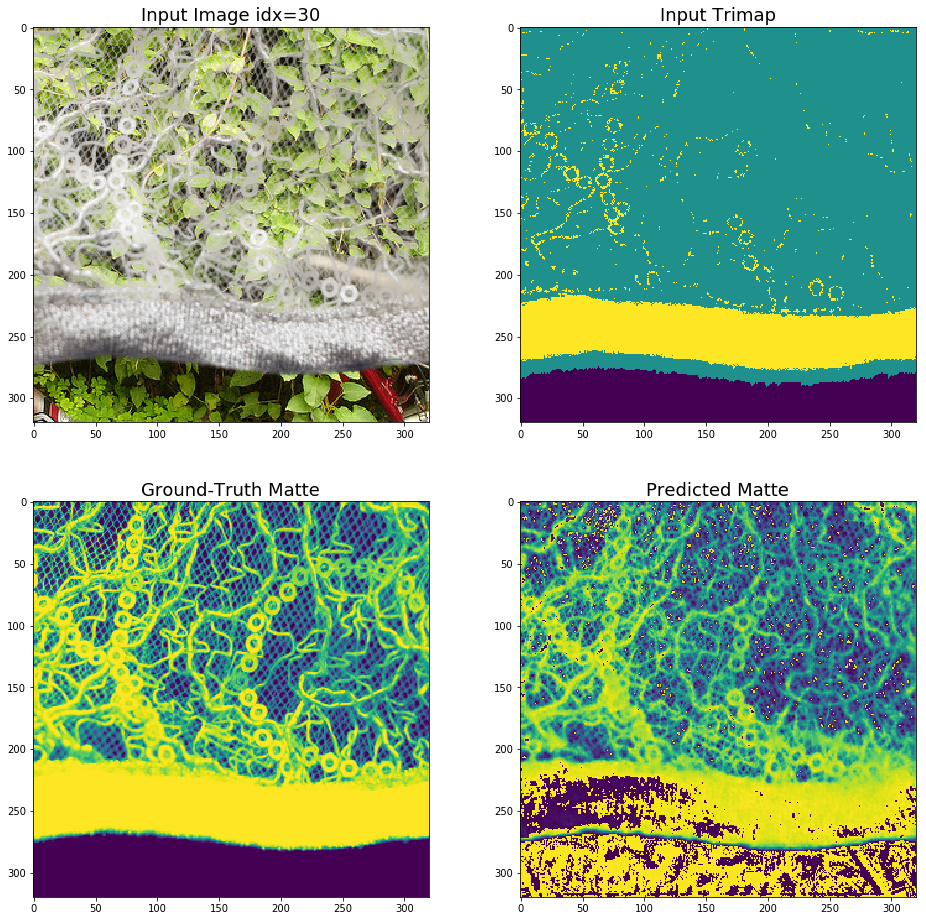

In [24]:
visualize(image_datasets['val'], -1, False)